[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/esm/blob/master/examples/variant_prediction.ipynb)

# ~~Supervised variant prediction with ESM~~

# (Supervised prediction of enzyme classification numbers with ESM)

**Note, this example notebook predates our work on zero-shot variant prediction, which is presented in `examples/variant-prediction`**.

This tutorial demonstrates how to train a simple variant predictor, i.e. we predict the biological activity of mutations of a protein, using fixed embeddings from ESM. You can adopt a similar protocol to train a model for any downstream task, even with limited data.

We will use a simple classifier in sklearn (or "head" on top of the transformer features) to predict the mutation effect from precomputed ESM embeddings. The embeddings for your dataset can be dumped once using a GPU. Then, the rest of your analysis can be done on CPU. 

### Background

In this particular example, we will train a model to predict the activity of ß-lactamase variants.

We provide the training in `examples/data/P62593.fasta`, a FASTA file where each entry contains:
- the mutated ß-lactamase sequence, where a single residue is mutated (swapped with another amino acid)
- the target value in the last field of the header, describing the scaled effect of the mutation

The [data originally comes](https://github.com/FowlerLab/Envision2017/blob/master/data/dmsTraining_2017-02-20.csv) from a deep mutational scan and was released with the Envision paper (Gray, et al. 2018)

### Goals
- Obtain an embedding (fixed-dimensional vector representation) for each mutated sequence.
- Train a regression model in sklearn that can predict the "effect" score given the embedding.


### Prerequisites
- You will need the following modules : tqdm, matplotlib, numpy, pandas, seaborn, scipy, scikit-learn
- You have obtained sequence embeddings for ß-lactamase as described in the README:
```
python scripts/extract.py esm1v_t33_650M_UR90S_1 examples/data/P62593.fasta examples/data/P62593_emb_esm1v/ --repr_layers 33 --include mean
```


### Table of Contents
1. [Prelims](#prelims)
1. [Loading Embeddings](#load_embeddings)
1. [Visualizing Embeddings](#viz_embeddings)
1. [Initializing / Running Grid Search](#grid_search)
1. [Browse Grid Search Results](#browse)
1. [Evaluating Results](#eval)

<a id='prelims'></a>
## Prelims

If you are using colab, then uncomment and run the cell below.
It will pip install the `esm` code, fetch the fasta file and the pre-computed embeddings.

In [1]:
# !pip install git+https://github.com/facebookresearch/esm.git
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
# !tar -xzf P62593_reprs.tar.gz
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
# !pwd
# !ls

In [4]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import esm

/stor/home/amh7958/miniconda3/envs/efficient-evolution/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

## Add the path to your embeddings here:


In [6]:
ecol_fasta_PATH = "../data/UP000000625_83333.fasta" # Path to P62593.fasta
polymerase_fasta_PATH = "../data/polymerases.fasta" # Path to P62593.fasta
EMB_PATH = "../output/UP000000625_83333_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 33

<a id='load_embeddings'></a>
## Load embeddings (Xs) and target effects (ys)
Our FASTA file is formatted as such:
```
>{index}|{mutation_id}|{effect}
{seq}
```
We will be extracting the effect from each entry.

Our embeddings are stored with the file name from fasta header: `{index}|{mutation_id}|{effect}.pt`

In [7]:
#ys = []
Xs = []
IDs = []
types = []
for header, _seq in esm.data.read_fasta(ecol_fasta_PATH):
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    ID = header.split("|")[1] 
    IDs.append(ID)
    Xs.append(embs['mean_representations'][EMB_LAYER])
    types.append("ecol")

for header, _seq in esm.data.read_fasta(polymerase_fasta_PATH):
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    ID = header.split("|")[1] 
    IDs.append(ID)
    Xs.append(embs['mean_representations'][EMB_LAYER])
    type = "RNAP-T7-like" if (header.split('|')[-1] in ("T7-pol", "T3-pol")) else "RNAP-other"
    types.append(type)
    
Xs = torch.stack(Xs, dim=0).numpy()
print(Xs.shape)

(4407, 1280)


### Train / Test Split

Here we choose to follow the Envision paper, using 80% of the data for training, but we actually found that pre-trained ESM embeddings require fewer downstream training examples to reach the same level of performance.

In [13]:
#train_size = 0.8
#Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

In [14]:
#Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

### PCA

Principal Component Analysis is a popular technique for dimensionality reduction. Given `n_features` (1280 in our case), PCA computes a new set of `X` that "best explain the data." We've found that this enables downstream models to be trained faster with minimal loss in performance.  

Here, we set `X` to 60, but feel free to change it!


In [8]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs)

In [9]:
column_names = [f'PC{i+1}' for i in range(Xs_train_pca.shape[1])]
df_Xs = pd.DataFrame(data=Xs_train_pca, columns=column_names)
df_Xs["Entry"] = IDs
df_Xs["Type"] = types

In [10]:
df_pol_data = pd.read_csv("../data/uniprotkb_2023_12_21_polymerases.tsv", sep='\t')
df_ecol_data = pd.read_csv("../data/uniprotkb_proteome_UP000000625_2023_12_21.tsv", sep='\t')

tsv_data = pd.concat([df_ecol_data, df_pol_data], axis=0, ignore_index=True)
tsv_data

,Entry,Entry Name,Gene Names,Length,EC number,Gene Ontology IDs
0,A5A616,MGTS_ECOLI,mgtS yneM b4599 JW1527.1,31,NaN,GO:0005886; GO:0010350
1,O32583,THIS_ECOLI,thiS thiG1 b4407 JW3955,66,NaN,GO:0000166; GO:0009228; GO:0009229; GO:0052837...
2,P00350,6PGD_ECOLI,gnd b2029 JW2011,468,1.1.1.44,GO:0004616; GO:0005829; GO:0006098; GO:0009051...
3,P00363,FRDA_ECOLI,frdA b4154 JW4115,602,1.3.5.1,GO:0000104; GO:0005829; GO:0005886; GO:0006113...
4,P00370,DHE4_ECOLI,gdhA b1761 JW1750,447,1.4.1.4,GO:0004354; GO:0005737; GO:0005829; GO:0006536...
...,...,...,...,...,...,...
4403,V9HVX0,YPAA_ECOLI,ypaA b4543,61,NaN,NaN
4404,P00581,DPOL_BPT7,5,704,2.7.7.7; 3.1.11.-,GO:0000166; GO:0003677; GO:0003887; GO:0004529...
4405,P0A8V2,RPOB_ECOLI,rpoB groN nitB rif ron stl stv tabD b3987 JW3950,1342,2.7.7.6,GO:0000345; GO:0003677; GO:0003899; GO:0005737...
4406,P20311,DPOL_BPT3,5,704,2.7.7.7; 3.1.11.-,GO:0000166; GO:0003677; GO:0003887; GO:0006261...


In [12]:
df_Xs_labeled = pd.merge(df_Xs, tsv_data, on='Entry', how="right", copy=False)
df_Xs_labeled["EC_1"] = [str(X).split(".")[0] for X in df_Xs_labeled["EC number"]]
#df_Xs_labeled

<AxesSubplot: xlabel='EC_1', ylabel='Length'>

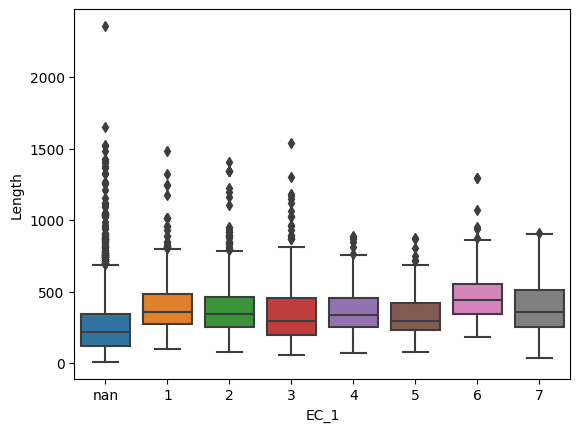

In [117]:
sns.boxplot(data=df_Xs_labeled, x="EC_1", y="Length")

<a id='viz_embeddings'></a>
## Visualize Embeddings

Here, we plot the first two principal components on the x- and y- axes. Each point is then colored by its scaled effect (what we want to predict).

Visually, we can see a separation based on color/effect, suggesting that our representations are useful for this task, without any task-specific training!

<AxesSubplot: xlabel='PC1', ylabel='PC3'>

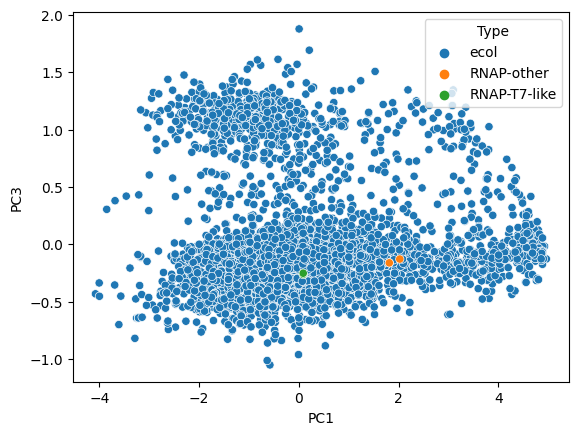

In [41]:
sns.scatterplot(data=df_Xs_labeled, x="PC1", y="PC3", hue="Type")

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

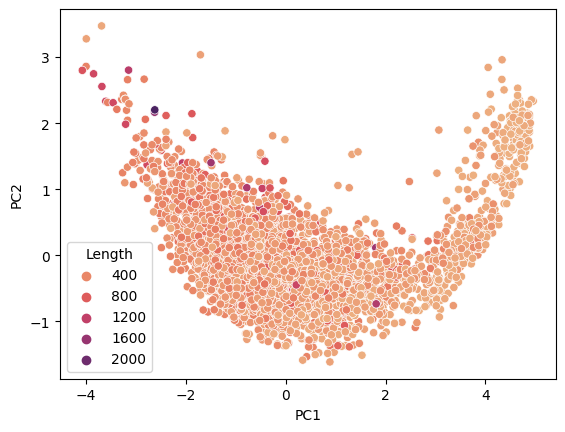

In [14]:
sns.scatterplot(data=df_Xs_labeled, x="PC1", y="PC2", hue="Length", palette="flare")

<AxesSubplot: xlabel='PC1', ylabel='PC3'>

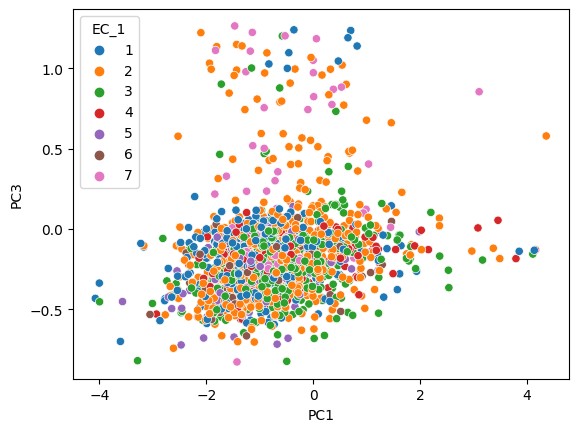

In [62]:
df_Xs_EC = df_Xs_labeled[df_Xs_labeled['EC_1'] != 'nan']
sns.scatterplot(data=df_Xs_EC, x="PC1", y="PC3", hue="EC_1")

## Train a support vector machine to predict EC numbers

### Data prep

In [68]:
# make a lookup table of gene ID-EC numbers
dict_ec = {key:value for (key,value) in zip(tsv_data["Entry"], tsv_data["EC number"])}

In [71]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(ecol_fasta_PATH):
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    gene_id = header.split("|")[1]
    ec = str(dict_ec[gene_id]).split(".")[0]
    if ec != "nan":
        Xs.append(embs['mean_representations'][EMB_LAYER])
        ys.append(ec)
    
Xs = torch.stack(Xs, dim=0).numpy()
print(Xs.shape)
print(len(ys))

(1707, 1280)
1707


In [73]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

In [74]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((1365, 1280), (342, 1280), 1365, 342)

### Fitting the classifier

In [121]:
# just using default parameters for a first pass
clf = SVC()
clf.fit(Xs_train, ys_train)

SVC()

In [122]:
predictions = list(clf.predict(Xs_test))
tot = len(ys_test)
correct = 0
for pred, actual in zip(predictions, ys_test):
    #print(f'{actual}: {pred}')
    if pred == actual:
        correct += 1
print(f'accuracy: {correct/tot}')

accuracy: 0.4269005847953216


In [123]:
weights = {
    "1": 1,
    "2": 1,
    "3": 1,
    "4": 2,
    "5": 2,
    "6": 5,
    "7": 5
}

In [124]:
# fitting the SVM with rare classes weighted
clf = SVC(class_weight = weights, probability=True)
clf.fit(Xs_train, ys_train)

SVC(class_weight={'1': 1, '2': 1, '3': 1, '4': 2, '5': 2, '6': 5, '7': 5},
    probability=True)

In [125]:
tot = len(ys_test)
predictions = list(clf.predict(Xs_test))
correct = 0
for pred, actual in zip(predictions, ys_test):
    #print(f'{actual}: {pred}')
    if pred == actual:
        correct += 1
print(f'accuracy: {correct/tot}')

#sns.scatterplot(x=predictions, y=ys_test)

accuracy: 0.4824561403508772


In [127]:
for pred, actual in zip(list(clf.decision_function(Xs_test)), ys_test):
    pass
    #print(actual)
    #print(pred)

### Confusion matrix

In [129]:
conf_matrix = confusion_matrix(ys_test, predictions)
conf_matrix

array([[24, 20,  3,  7,  0,  7,  1],
       [ 4, 92,  3, 11,  0,  2,  0],
       [ 4, 67, 15,  1,  0,  4,  2],
       [ 3,  8,  3, 14,  0,  0,  0],
       [ 1, 11,  0,  2,  0,  4,  0],
       [ 0,  2,  0,  1,  0,  7,  0],
       [ 0,  4,  1,  1,  0,  0, 13]])

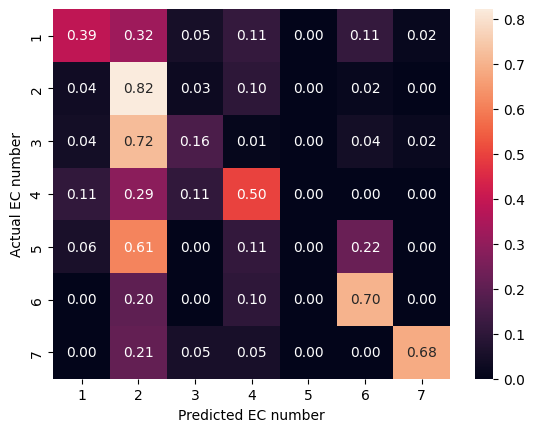

In [138]:
cmn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f')
ax = plt.gca()

# Set new labels for the axes
ax.set(xlabel='Predicted EC number', ylabel='Actual EC number')
ax.yaxis.set_ticklabels(range(1,8))
ax.xaxis.set_ticklabels(range(1,8))
plt.show()